## Preambule

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
path_to_save = "K:/Data/Data_effortsharing/EffortSharingExports/PBLreport/"
path_to_read = "K:/Data/Data_effortsharing/DataUpdate_ongoing/startyear_2021/"

## Read in general data

In [11]:
xr_2030 = xr.open_dataset(path_to_read+"Aggregated_files/xr_alloc_2030_GHG_incl.nc").load()
xr_2040 = xr.open_dataset(path_to_read+"Aggregated_files/xr_alloc_2040_GHG_incl.nc").load()
xr_dataread = xr.open_dataset(path_to_read+"xr_dataread.nc").load()
xr_nld = xr.open_dataset(path_to_read+"Allocations_GHG_incl/xr_alloc_NLD.nc").load()
xr_usa = xr.open_dataset(path_to_read+"Allocations_GHG_incl/xr_alloc_USA.nc").load()
xr_engage = xr.open_dataset(path_to_read+"../xr_policyscen.nc").load()
xr_engage_co2 = xr.open_dataset(path_to_read+"../xr_policyscen_co2.nc").load()

In [12]:
rules = ['GF', 'PC', 'PCC', 'AP', 'ECPC', 'GDR', 'PCB', 'PCB_lin']
standard_settings = {}
median_settings = {"NonCO2red": 0.5,
                   "Convergence_year": 2050,
                   "Discount_factor": 0,
                   "Historical_startyear": 1990,
                   "Capability_threshold": 'Th',
                   "RCI_weight": "Half",
                   "Scenario": "SSP2"}

## Addendum numbers

Reading numbers like they were in table 4.1

In [13]:
dict_fig_4_1 = {}
list_rule = []
list_med = []
list_min = []
list_max = []
list_med2 = []
list_min2 = []
list_max2 = []
list_time = []
for rule_i, rule in enumerate(rules):
    val_med = np.array(xr_nld.sel(Temperature=1.6, Risk=0.5, NegEmis=0.5, Timing='Immediate', **median_settings, **standard_settings)[rule])
    val_min = np.array(xr_nld.sel(Temperature=1.6, Risk=0.5, NegEmis=0.5, **standard_settings).min(dim=median_settings.keys()).min(dim='Timing')[rule])
    val_max = np.array(xr_nld.sel(Temperature=1.6, Risk=0.5, NegEmis=0.5, **standard_settings).max(dim=median_settings.keys()).max(dim='Timing')[rule])
    val_med2 = np.array(xr_nld.sel(Temperature=2, Risk=0.33, NegEmis=0.5, Timing='Immediate', **median_settings, **standard_settings)[rule])
    val_min2 = np.array(xr_nld.sel(Temperature=2, Risk=0.33, NegEmis=0.5, **standard_settings).min(dim=median_settings.keys()).min(dim='Timing')[rule])
    val_max2 = np.array(xr_nld.sel(Temperature=2, Risk=0.33, NegEmis=0.5, **standard_settings).max(dim=median_settings.keys()).max(dim='Timing')[rule])
    list_rule += [rule]*len(val_med)
    list_med += list(val_med)
    list_max += list(val_max)
    list_min += list(val_min)
    list_med2 += list(val_med2)
    list_max2 += list(val_max2)
    list_min2 += list(val_min2)
    list_time += list(np.array(xr_nld.Time))
dict_fig_4_1['Rule'] = list_rule
dict_fig_4_1['Median_15'] = list_med
dict_fig_4_1['Minimum_15'] = list_min
dict_fig_4_1['Maximum_15'] = list_max
dict_fig_4_1['Median_20'] = list_med2
dict_fig_4_1['Minimum_20'] = list_min2
dict_fig_4_1['Maximum_20'] = list_max2
dict_fig_4_1['Time'] = list_time
df_fig_4_1 = pd.DataFrame(dict_fig_4_1)
emis_1990 = float(xr_dataread.GHG_hist.sel(Region='NLD', Time=1990))

In [14]:
xr_dataread_old = xr.open_dataset(path_to_save+"xr_dataread_old.nc").load()
xr_2030_old = xr.open_dataset(path_to_save+"Report data files/xr_alloc_2030.nc").load().sel(Region='NLD')
xr_2040_old = xr.open_dataset(path_to_save+"Report data files/xr_alloc_2040.nc").load().sel(Region='NLD')
df_old = pd.read_excel(path_to_save+"data_fig_4_1_old.xlsx")
emis_1990_old = float(xr_dataread_old.GHG_hist.sel(Region='NLD', Time=1990))

In [15]:
df_old_melt = df_old.melt(id_vars=['Rule', 'Time'], value_vars=['Median_15', 'Minimum_15', 'Maximum_15', 'Median_20', 'Minimum_20', 'Maximum_20'], var_name='Variable', value_name='Value')
df_old_melt = df_old_melt.set_index(['Rule', 'Time', 'Variable'])
xr_old = xr.Dataset.from_dataframe(df_old_melt)

df_fig_4_1m = df_fig_4_1.melt(id_vars=['Rule', 'Time'], value_vars=['Median_15', 'Minimum_15', 'Maximum_15', 'Median_20', 'Minimum_20', 'Maximum_20'], var_name='Variable', value_name='Value')
df_fig_4_1m = df_fig_4_1m.set_index(['Rule', 'Time', 'Variable'])
xr_41 = xr.Dataset.from_dataframe(df_fig_4_1m)

Computing global budgets

This difference is solely because of slightly different handling of non-CO2 adjustment, which unfortunately leads (because of the super high sensitivity to non-CO2) to approx 80 Gt CO2 difference in 1.5 (Forster is in between), 25 Gt CO2 difference for 1.56/1.6 and approx 100 Gt CO2 difference for 2.0. In both versions, we took the nth quantile of nonco2 reduction from the AR6 database, checked how much reduction that was and inserted that in the table from Lamboll et al. to get the RCB effect, also taking into account that the Forster budgets assumed particular non-CO2 pathway trajectories that may slightly deviate from the exact AR6 median for a given peak temperature segment (i.e, leading to a small change from Forster in the budget at nonco2red=0.5). The difference below (between new and old) lies in the non-CO2 pathways themselves, which are refined in the new version mostly because of smoothening across temperature levels.

In [16]:
print("Old RCB for 1.5 (50%) from 2021:", float(xr_dataread_old.Budget.sel(Temperature=1.5, Risk=0.5, NonCO2red=0.5)))
print("Old RCB for 1.56 (50%) from 2021:", float(xr_dataread_old.Budget.sel(Temperature=1.56, Risk=0.5, NonCO2red=0.5)))
print("Old RCB for 2.0 (67%) from 2021:", float(xr_dataread_old.Budget.sel(Temperature=2.0, Risk=0.33, NonCO2red=0.5)))
print("")
print("New RCB for 1.5 (50%) from 2021:", float(xr_dataread.Budget.sel(Temperature=1.5, Risk=0.5, NonCO2red=0.5)))
print("New RCB for 1.6 (50%) from 2021:", float(xr_dataread.Budget.sel(Temperature=1.6, Risk=0.5, NonCO2red=0.5)))
print("New RCB for 2.0 (67%) from 2021:", float(xr_dataread.Budget.sel(Temperature=2.0, Risk=0.33, NonCO2red=0.5)))

Old RCB for 1.5 (50%) from 2021: 379.5328843092957
Old RCB for 1.56 (50%) from 2021: 487.5433502563473
Old RCB for 2.0 (67%) from 2021: 1054.3516703518935

New RCB for 1.5 (50%) from 2021: 299.18674172430786
New RCB for 1.6 (50%) from 2021: 462.644404745756
New RCB for 2.0 (67%) from 2021: 913.91148194326


In [33]:
xr_dataread_old.GHG_globe.sel(Time=2030, Temperature=1.56, NegEmis=0.3, NonCO2red=[0.1, 0.5, 0.9], Risk=0.5)

<xarray.DataArray 'GHG_globe' (NonCO2red: 3, Timing: 2)> Size: 48B
array([[25176.09686307, 22088.92818974],
       [35211.75359841, 28240.70095745],
       [40962.96928942, 30875.89904968]])
Coordinates:
    Time         int32 4B 2030
    Temperature  float64 8B 1.56
    Risk         float64 8B 0.5
  * NonCO2red    (NonCO2red) float64 24B 0.1 0.5 0.9
    NegEmis      float64 8B 0.3
  * Timing       (Timing) <U9 72B 'Delayed' 'Immediate'
    Version      <U6 24B 'HISTTP'
    variable     <U8 32B 'CO2_base'
    source       <U25 100B 'PRIMAP-hist_v2.5_final_nr'

In [41]:
emis_1990_nld = xr_dataread_old.GHG_hist.sel(Time=1990, Region='NLD')

(array([ 3.,  4.,  4.,  8., 10.,  8., 16., 14., 16., 19., 17., 19., 14.,
        16., 14., 16., 19., 20., 24., 30., 28., 30., 30., 30., 23., 26.,
        21., 16.,  9., 10., 10.,  9.,  9.,  6.,  9.,  4.,  6.,  4.,  2.,
         4.,  6.,  4.,  3.,  4.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([0.50761934, 0.51831583, 0.52901233, 0.53970882, 0.55040531,
        0.5611018 , 0.5717983 , 0.58249479, 0.59319128, 0.60388777,
        0.61458426, 0.62528076, 0.63597725, 0.64667374, 0.65737023,
        0.66806673, 0.67876322, 0.68945971, 0.7001562 , 0.7108527 ,
        0.72154919, 0.73224568, 0.74294217, 0.75363866, 0.76433516,
        0.77503165, 0.78572814, 0.79642463, 0.80712113, 0.81781762,
        0.82851411, 0.8392106 , 0.8499071 , 0.86060359, 0.87130008,
        0.88199657, 0.89269306, 0.90338956, 0.91408605, 0.92478254,
        0.93547903, 0.94617553, 0.95687202, 0.96756851, 0.978265  ,
        0.9889615 , 0.99965799, 1.01035448, 1.02105097, 1.03174746,
        1.04244396]),
 <BarContainer

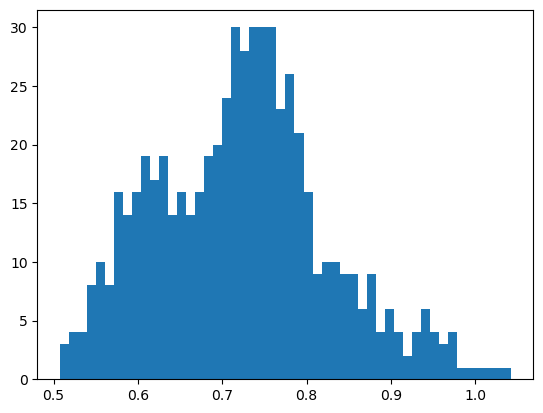

In [57]:
plt.hist(np.array((emis_1990_nld-xr_2030_old.sel(Risk=0.5, Temperature=1.56, NegEmis=0.3).ECPC)/emis_1990_nld).flatten(), bins=50)

In [73]:
((emis_1990_nld-xr_2030_old.sel(Risk=0.5, Temperature=1.56, NegEmis=0.3).ECPC)/emis_1990_nld).sel(NonCO2red=0.1, Discount_factor=0, Historical_startyear=1990)

<xarray.DataArray (Timing: 2, Scenario: 5)> Size: 80B
array([[0.74665447, 0.75118583, 0.75634994, 0.76036492, 0.74281759],
       [0.81185093, 0.81841236, 0.82589   , 0.83170372, 0.80629511]])
Coordinates: (12/13)
    Region                <U16 64B 'NLD'
    Version               <U6 24B 'HISTTP'
    variable              <U8 32B 'CO2_base'
    source                <U25 100B 'PRIMAP-hist_v2.5_final_nr'
  * Scenario              (Scenario) <U4 80B 'SSP1' 'SSP2' 'SSP3' 'SSP4' 'SSP5'
    Temperature           float64 8B 1.56
    ...                    ...
    NonCO2red             float64 8B 0.1
    NegEmis               float64 8B 0.3
  * Timing                (Timing) <U9 72B 'Delayed' 'Immediate'
    Discount_factor       float64 8B 0.0
    Historical_startyear  int64 8B 1990
    Time                  int32 4B 1990

In [59]:
np.mean(np.array((emis_1990_nld-xr_2030_old.sel(Risk=0.5, Temperature=1.56, NegEmis=0.3).ECPC)/emis_1990_nld).flatten())

0.7233924527960832

Computing reduction numbers

The differences are because of a few updates:
* Slight changes in 2030 and 2040 global reductions because of different RCB (see above)
* 1.5-1.6 does now not have any delayed action anymore (in the old version only 1.5, but 1.56 did have it)
* ECPC is changed to assure payment of the historical debt within a certain time frame (convergence year)

In [17]:
red_old = (xr_old - emis_1990_old) / emis_1990_old
red_new = (xr_41 - emis_1990) / emis_1990

In [18]:
print('='*75)
print('Default values in 2030 in New')
for rule in ['GF', 'PCC', 'PC', 'PCB_lin', 'ECPC', 'AP', 'GDR']:
    dat = np.array(((emis_1990-xr_nld.sel(Time=2030, Temperature=[1.5, 1.6, 2.0], Risk=0.5,  NegEmis=0.5, Timing='Immediate', **median_settings))/emis_1990)[rule]).round(2)
    print(f"{rule:<20} {"{0:0.2f}".format(dat[0]):<20} {"{0:0.2f}".format(dat[1]):<20} {"{0:0.2f}".format(dat[2]):<20}")
print('='*75)
print('Default values in 2030 in OLD')
print(f"{'Rule':<20} {'Red (1.5)':<20} {'Red (1.5+)':<20} {'Red (<2.0)':<20}")
for rule in ['GF', 'PCC', 'PC', 'PCB_lin', 'ECPC', 'AP', 'GDR']:
    dat = np.array(((emis_1990_old-xr_2030_old.sel(Temperature=[1.5, 1.56, 2.0], Risk=0.5,  NegEmis=0.5, Timing='Immediate', **median_settings))/emis_1990_old)[rule]).round(2)
    print(f"{rule:<20} {"{0:0.2f}".format(dat[0]):<20} {"{0:0.2f}".format(dat[1]):<20} {"{0:0.2f}".format(dat[2]):<20}")

Default values in 2030 in New
GF                   0.70                 0.56                 0.31                
PCC                  0.73                 0.60                 0.38                
PC                   0.80                 0.70                 0.54                
PCB_lin              0.91                 0.69                 0.40                
ECPC                 1.99                 1.88                 1.69                
AP                   0.95                 0.80                 0.54                
GDR                  2.18                 1.74                 0.97                
Default values in 2030 in OLD
Rule                 Red (1.5)            Red (1.5+)           Red (<2.0)          
GF                   0.65                 0.58                 0.33                
PCC                  0.68                 0.62                 0.40                
PC                   0.77                 0.72                 0.55                
PCB_lin         

In [19]:
print('='*50)
print('Minimum values in 2030 in OLD')
for rule in ['GF', 'PCC', 'PC', 'PCB_lin', 'ECPC', 'AP', 'GDR']:
    print(rule, np.array(((emis_1990_old-xr_2030_old.sel(Temperature=[1.5, 1.56, 2.0], Risk=0.5,  NegEmis=0.5, Timing='Immediate'))/emis_1990_old).min(dim=median_settings.keys())[rule]).round(2))
print('='*50)
print('Minimum values in 2030 in New')
for rule in ['GF', 'PCC', 'PC', 'PCB_lin', 'ECPC', 'AP', 'GDR']:
    print(rule, np.array(((emis_1990-xr_nld.sel(Time=2030, Temperature=[1.5, 1.6, 2.0], Risk=0.5,  NegEmis=0.5, Timing='Immediate'))/emis_1990).min(dim=median_settings.keys())[rule]).round(2))

Minimum values in 2030 in OLD
GF [0.57 0.52 0.31]
PCC [0.59 0.54 0.34]
PC [0.72 0.68 0.54]
PCB_lin [0.62 0.57 0.43]
ECPC [0.67 0.63 0.45]
AP [0.78 0.74 0.52]
GDR [0.99 0.91 0.58]
Minimum values in 2030 in New
GF [0.64 0.52 0.28]
PCC [0.66 0.54 0.31]
PC [0.76 0.68 0.52]
PCB_lin [0.75 0.6  0.39]
ECPC [0.81 0.7  0.48]
AP [0.89 0.76 0.51]
GDR [1.18 0.98 0.61]


In [90]:
print('='*50)
print('Maximum values in 2030 in OLD')
for rule in ['GF', 'PCC', 'PC', 'PCB_lin', 'ECPC', 'AP', 'GDR']:
    print(rule, np.array(((emis_1990_old-xr_2030_old.sel(Temperature=[1.5, 1.56, 2.0], Risk=0.5,  NegEmis=0.5, Timing='Immediate'))/emis_1990_old).max(dim=median_settings.keys())[rule]).round(2))
print('='*50)
print('Maximum values in 2030 in New')
for rule in ['GF', 'PCC', 'PC', 'PCB_lin', 'ECPC', 'AP', 'GDR']:
    print(rule, np.array(((emis_1990-xr_nld.sel(Time=2030, Temperature=[1.5, 1.6, 2.0], Risk=0.5,  NegEmis=0.5, Timing='Immediate'))/emis_1990).max(dim=median_settings.keys())[rule]).round(2))

Maximum values in 2030 in OLD
GF [0.83 0.67 0.34]
PCC [0.86 0.73 0.44]
PC [0.89 0.78 0.56]
PCB_lin [0.91 0.9  0.43]
ECPC [1.16 1.03 0.77]
AP [1.06 0.9  0.54]
GDR [3.48 2.75 1.19]
Maximum values in 2030 in New
GF [0.85 0.61 0.31]
PCC [0.87 0.68 0.42]
PC [0.9  0.74 0.54]
PCB_lin [0.91 0.82 0.41]
ECPC [3.71 3.56 3.37]
AP [1.11 0.86 0.56]
GDR [3.82 2.74 1.35]


In [9]:
# Print the header with alignment
print("-" * 100)
print("THIS IS THE NEW TABLE")
print("-" * 100)
print(f"{'Rule':<20} {'Min red (1.5)':<20} {'Max red (1.5)':<20} {'Min red (2.0)':<20} {'Max red (2.0)':<20}")
print("-" * 100)
year = 2030
print('-> Year ', year)
for rule in rules:
    # Calculate the values
    max_value = np.round(-float((df_fig_4_1[(df_fig_4_1.Time == year) & (df_fig_4_1.Rule == rule)].Maximum_15 - emis_1990) / emis_1990), 2)
    min_value = np.round(-float((df_fig_4_1[(df_fig_4_1.Time == year) & (df_fig_4_1.Rule == rule)].Minimum_15 - emis_1990) / emis_1990), 2)
    
    max_value2 = np.round(-float((df_fig_4_1[(df_fig_4_1.Time == year) & (df_fig_4_1.Rule == rule)].Maximum_20 - emis_1990) / emis_1990), 2)
    min_value2 = np.round(-float((df_fig_4_1[(df_fig_4_1.Time == year) & (df_fig_4_1.Rule == rule)].Minimum_20 - emis_1990) / emis_1990), 2)
    
    # Print the results with aligned columns
    print(f"{rule:<20} {max_value:<20} {min_value:<20} {max_value2:<20} {min_value2:<20}")
print("-" * 100)
year = 2040
print('-> Year ', year)
for rule in rules:
    # Calculate the values
    max_value = np.round(-float((df_fig_4_1[(df_fig_4_1.Time == year) & (df_fig_4_1.Rule == rule)].Maximum_15 - emis_1990) / emis_1990), 2)
    min_value = np.round(-float((df_fig_4_1[(df_fig_4_1.Time == year) & (df_fig_4_1.Rule == rule)].Minimum_15 - emis_1990) / emis_1990), 2)
    
    max_value2 = np.round(-float((df_fig_4_1[(df_fig_4_1.Time == year) & (df_fig_4_1.Rule == rule)].Maximum_20 - emis_1990) / emis_1990), 2)
    min_value2 = np.round(-float((df_fig_4_1[(df_fig_4_1.Time == year) & (df_fig_4_1.Rule == rule)].Minimum_20 - emis_1990) / emis_1990), 2)
    
    # Print the results with aligned columns
    print(f"{rule:<20} {max_value:<20} {min_value:<20} {max_value2:<20} {min_value2:<20}")
print("-" * 100)

----------------------------------------------------------------------------------------------------
THIS IS THE NEW TABLE
----------------------------------------------------------------------------------------------------
Rule                 Min red (1.5)        Max red (1.5)        Min red (2.0)        Max red (2.0)       
----------------------------------------------------------------------------------------------------
-> Year  2030
GF                   0.52                 0.61                 0.23                 0.38                
PC                   0.68                 0.74                 0.49                 0.59                
PCC                  0.54                 0.68                 0.26                 0.48                
AP                   0.76                 0.86                 0.46                 0.62                
ECPC                 0.7                  3.56                 0.43                 3.41                
GDR                  0.98      

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10588\1329158707.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  max_value = np.round(-float((df_fig_4_1[(df_fig_4_1.Time == year) & (df_fig_4_1.Rule == rule)].Maximum_15 - emis_1990) / emis_1990), 2)
C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10588\1329158707.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min_value = np.round(-float((df_fig_4_1[(df_fig_4_1.Time == year) & (df_fig_4_1.Rule == rule)].Minimum_15 - emis_1990) / emis_1990), 2)
C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10588\1329158707.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  max_value2 = np.round(-float((df_fig_4_1[(df_fig_4_1.Time == year) & (df_fig_

## Exports

#### Schema 1 (general infographic)

In [212]:
emis_1990 = float(xr_dataread.GHG_hist.sel(Region='NLD', Time=1990))
dict_schema_1_h = {}
list_var = list(np.array(xr_dataread.GHG_hist.sel(Region='NLD', Time=np.arange(1990, 2021.5))))
list_time = list(np.arange(1990, 2021.5))
dict_schema_1_h['Time'] = list_time
dict_schema_1_h['GHG_historical'] = list_var
dict_schema_1_h['Red_wrt_1990'] = (emis_1990-np.array(list_var))/emis_1990

df_schema_1_h = pd.DataFrame(dict_schema_1_h)
df_schema_1_h.to_excel(path_to_save+"data_sch1_hist.xlsx", index=False)

In [213]:
emis_2021 = float(xr_dataread.GHG_hist.sel(Region='NLD', Time=2021))
emis_2030_high = 123
emis_2030_low = 97
time = np.arange(2021, 2031)
interp_high = np.interp(time, [2021, 2030], [emis_2021, emis_2030_high])
interp_low = np.interp(time, [2021, 2030], [emis_2021, emis_2030_low])

In [214]:
dict_schema_1_kev = {}
list_time = list(np.arange(2021, 2031))
dict_schema_1_kev['Time'] = list_time
dict_schema_1_kev['GHG_kev_high'] = interp_high
dict_schema_1_kev['GHG_kev_low'] = interp_low

dict_schema_1_kev['GHG_kev_high_red_wrt_1990'] = (emis_1990-interp_high)/emis_1990
dict_schema_1_kev['GHG_kev_low_red_wrt_1990'] = (emis_1990-interp_low)/emis_1990

df_schema_1_kev = pd.DataFrame(dict_schema_1_kev)
df_schema_1_kev.to_excel(path_to_save+"data_sch1_kev.xlsx", index=False)

In [215]:
dict_schema_1_effortsharing = {}
dict_schema_1_effortsharing['Fairness_15_GHG'] = np.array(xr_nld.sel(Temperature=1.6, Time=2040, Timing='Immediate', NegEmis=0.5, Risk=0.5, **median_settings)[rules].to_array())
dict_schema_1_effortsharing['Fairness_20_GHG'] = np.array(xr_nld.sel(Time=2040, Temperature=2.0, Timing='Immediate', Risk=0.33, NegEmis=0.5, **median_settings)[rules].to_array())
dict_schema_1_effortsharing['Fairness_15_red_1990'] = (emis_1990-np.array(xr_nld.sel(Time=2040, Temperature=1.6, Timing='Immediate', NegEmis=0.5, Risk=0.33, **median_settings)[rules].to_array()))/emis_1990
dict_schema_1_effortsharing['Fairness_20_red_1990'] = (emis_1990-np.array(xr_nld.sel(Time=2040, Temperature=2, Timing='Immediate', Risk=0.33, NegEmis=0.5, **median_settings)[rules].to_array()))/emis_1990
dict_schema_1_effortsharing['Allocation'] = rules

df_schema_1_effortsharing = pd.DataFrame(dict_schema_1_effortsharing)
df_schema_1_effortsharing.to_excel(path_to_save+"data_sch1_es.xlsx", index=False)

#### Schema 2 (outline of report)

In [216]:
emis_1990 = float(xr_dataread.GHG_hist.sel(Region='EARTH', Time=1990))
dict_schema_2_h = {}
list_var = list(np.array(xr_dataread.GHG_hist.sel(Region='EARTH', Time=np.arange(1990, 2021.5))))
list_time = list(np.arange(1990, 2021.5))

dict_schema_2_h['Time'] = list_time
dict_schema_2_h['GHG_historical_globe'] = list_var

df_schema_2_h = pd.DataFrame(dict_schema_2_h)
df_schema_2_h.to_excel(path_to_save+"data_sch2_hist.xlsx", index=False)

In [217]:
emis_1990 = float(xr_dataread.GHG_hist.sel(Region='EARTH', Time=1990))
dict_schema_2_h = {}
list_time = list(np.arange(2021, 2101))
list_var_15 = list(np.array(xr_dataread.GHG_globe.sel(NegEmis=0.5, NonCO2red=0.5, Temperature=1.5, Risk=0.5, Timing='Immediate', Time=np.arange(2021, 2101))))
list_var_20 = list(np.array(xr_dataread.GHG_globe.sel(NegEmis=0.5, NonCO2red=0.5, Temperature=2.0, Risk=0.5, Timing='Immediate', Time=np.arange(2021, 2101))))
#list_var_23 = list(np.array(xr_dataread.GHG_globe.sel(NegEmis=0.5, NonCO2red=0.5, Temperature=2.3, Risk=0.5, Timing='Immediate', Time=np.arange(2021, 2101))))

dict_schema_2_h['Time'] = list_time
dict_schema_2_h['GHG_projection_15'] = list_var_15
dict_schema_2_h['GHG_projection_20'] = list_var_20
#dict_schema_2_h['GHG_projection_23'] = list_var_23

df_schema_2_h = pd.DataFrame(dict_schema_2_h)
df_schema_2_h.to_excel(path_to_save+"data_sch2_proj.xlsx", index=False)

#### Figure 2.2 (global pathways)

In [218]:
emis_1990 = float(xr_dataread.GHG_hist.sel(Region='EARTH', Time=1990))
dict_schema_2_h = {}
list_time = list(np.arange(2021, 2101))
list_ghg_15 = list(np.array(xr_dataread.GHG_globe.sel(NegEmis=0.5, NonCO2red=0.5, Temperature=1.6, Risk=0.5, Timing='Immediate', Time=np.arange(2021, 2101))))
list_ghg_20 = list(np.array(xr_dataread.GHG_globe.sel(NegEmis=0.5, NonCO2red=0.5, Temperature=2.0, Risk=0.33, Timing='Immediate', Time=np.arange(2021, 2101))))
list_co2_15 = list(np.array(xr_dataread.CO2_globe.sel(NegEmis=0.5, NonCO2red=0.5, Temperature=1.6, Risk=0.5, Timing='Immediate', Time=np.arange(2021, 2101))))
list_co2_20 = list(np.array(xr_dataread.CO2_globe.sel(NegEmis=0.5, NonCO2red=0.5, Temperature=2.0, Risk=0.33, Timing='Immediate', Time=np.arange(2021, 2101))))

dict_schema_2_h['Time'] = list_time

dict_schema_2_h['GHG_15_low'] = list(np.array(xr_dataread.GHG_globe.sel(Temperature=1.6, Risk=0.5, NegEmis=[0.33, 0.5, 0.67], Time=np.arange(2021, 2101)).min(dim=['NonCO2red', 'Timing', 'NegEmis'])))
dict_schema_2_h['GHG_15_med'] = list_ghg_15
dict_schema_2_h['GHG_15_high'] = list(np.array(xr_dataread.GHG_globe.sel(Temperature=1.6, Risk=0.5, NegEmis=[0.33, 0.5, 0.67], Time=np.arange(2021, 2101)).max(dim=['NonCO2red', 'Timing', 'NegEmis'])))
dict_schema_2_h['CO2_15_low'] = list(np.array(xr_dataread.CO2_globe.sel(Temperature=1.6, Risk=0.5, NegEmis=[0.33, 0.5, 0.67], Time=np.arange(2021, 2101)).min(dim=['NonCO2red', 'Timing', 'NegEmis'])))
dict_schema_2_h['CO2_15_med'] = list_co2_15
dict_schema_2_h['CO2_15_high'] = list(np.array(xr_dataread.CO2_globe.sel(Temperature=1.6, Risk=0.5, NegEmis=[0.33, 0.5, 0.67], Time=np.arange(2021, 2101)).max(dim=['NonCO2red', 'Timing', 'NegEmis'])))

dict_schema_2_h['GHG_20_low'] = list(np.array(xr_dataread.GHG_globe.sel(Temperature=2.0, Risk=0.33, NegEmis=[0.33, 0.5, 0.67], Time=np.arange(2021, 2101)).min(dim=['NonCO2red', 'Timing', 'NegEmis'])))
dict_schema_2_h['GHG_20_med'] = list_ghg_20
dict_schema_2_h['GHG_20_high'] = list(np.array(xr_dataread.GHG_globe.sel(Temperature=2, Risk=0.33, NegEmis=[0.33, 0.5, 0.67], Time=np.arange(2021, 2101)).max(dim=['NonCO2red', 'Timing', 'NegEmis'])))
dict_schema_2_h['CO2_20_low'] = list(np.array(xr_dataread.CO2_globe.sel(Temperature=2, Risk=0.33, NegEmis=[0.33, 0.5, 0.67], Time=np.arange(2021, 2101)).min(dim=['NonCO2red', 'Timing', 'NegEmis'])))
dict_schema_2_h['CO2_20_med'] = list_co2_20
dict_schema_2_h['CO2_20_high'] = list(np.array(xr_dataread.CO2_globe.sel(Temperature=2, Risk=0.33, NegEmis=[0.33, 0.5, 0.67], Time=np.arange(2021, 2101)).max(dim=['NonCO2red', 'Timing', 'NegEmis'])))

df_schema_2_h = pd.DataFrame(dict_schema_2_h)
df_schema_2_h.to_excel(path_to_save+"data_fig_2_2.xlsx", index=False)

In [219]:
xr_use = xr_engage.CurPol.sel(Region='EARTH')
xr_use_co2 = xr_engage_co2.CurPol.sel(Region='EARTH')

dict_eng = {}
dict_eng['Time'] = np.array(xr_use.Time)
dict_eng['Mean_GHG'] = np.array(xr_use.mean(dim='Model'))
dict_eng['Max_GHG'] = np.array(xr_use.max(dim='Model'))
dict_eng['Min_GHG'] = np.array(xr_use.min(dim='Model'))
dict_eng['Mean_CO2'] = np.array(xr_use_co2.mean(dim='Model'))
dict_eng['Max_CO2'] = np.array(xr_use_co2.max(dim='Model'))
dict_eng['Min_CO2'] = np.array(xr_use_co2.min(dim='Model'))
df_global_pathways = pd.DataFrame(dict_eng)
df_global_pathways.to_excel(path_to_save+"data_fig_2_2_curpol.xlsx", index=False)

In [220]:
xr_use = xr_dataread.GHG_hist.sel(Region='EARTH')
xr_use_co2 = xr_dataread.CO2_hist.sel(Region='EARTH')

dict_eng = {}
dict_eng['Time'] = np.array(xr_use.Time)
dict_eng['GHG_hist'] = np.array(xr_use)
dict_eng['CO2_hist'] = np.array(xr_use_co2)
df_global_pathways = pd.DataFrame(dict_eng)
df_global_pathways.to_excel(path_to_save+"data_fig_2_2_hist.xlsx", index=False)

#### Figure 4.1 (Netherlands zoom)

In [221]:
dict_fig_4_1 = {}
list_rule = []
list_med = []
list_min = []
list_max = []
list_med2 = []
list_min2 = []
list_max2 = []
list_time = []
for rule_i, rule in enumerate(rules):
    val_med = np.array(xr_nld.sel(Temperature=1.6, Risk=0.5, NegEmis=0.5, Timing='Immediate', **median_settings, **standard_settings)[rule])
    val_min = np.array(xr_nld.sel(Temperature=1.6, Risk=0.5, NegEmis=0.5, **standard_settings).min(dim=median_settings.keys()).min(dim='Timing')[rule])
    val_max = np.array(xr_nld.sel(Temperature=1.6, Risk=0.5, NegEmis=0.5, **standard_settings).max(dim=median_settings.keys()).max(dim='Timing')[rule])
    val_med2 = np.array(xr_nld.sel(Temperature=2, Risk=0.33, NegEmis=0.5, Timing='Immediate', **median_settings, **standard_settings)[rule])
    val_min2 = np.array(xr_nld.sel(Temperature=2, Risk=0.33, NegEmis=0.5, **standard_settings).min(dim=median_settings.keys()).min(dim='Timing')[rule])
    val_max2 = np.array(xr_nld.sel(Temperature=2, Risk=0.33, NegEmis=0.5, **standard_settings).max(dim=median_settings.keys()).max(dim='Timing')[rule])
    list_rule += [rule]*len(val_med)
    list_med += list(val_med)
    list_max += list(val_max)
    list_min += list(val_min)
    list_med2 += list(val_med2)
    list_max2 += list(val_max2)
    list_min2 += list(val_min2)
    list_time += list(np.array(xr_nld.Time))
dict_fig_4_1['Rule'] = list_rule
dict_fig_4_1['Median_15'] = list_med
dict_fig_4_1['Minimum_15'] = list_min
dict_fig_4_1['Maximum_15'] = list_max
dict_fig_4_1['Median_20'] = list_med2
dict_fig_4_1['Minimum_20'] = list_min2
dict_fig_4_1['Maximum_20'] = list_max2
dict_fig_4_1['Time'] = list_time

df_fig_4_1 = pd.DataFrame(dict_fig_4_1)
df_fig_4_1.to_excel(path_to_save+"data_fig_4_1.xlsx", index=False)

#### Figure 4.2 (temperature levels on horizontal)

(The diagonal is used to obtain specific values of NegEmis per temperature level)

In [233]:
emis_1990 = float(xr_dataread.GHG_hist.sel(Region='NLD', Time=1990))

dict_fig_4_2 = {}
list_rule = []
list_med = []
list_min = []
list_max = []
list_temp = []
for rule_i, rule in enumerate(rules):
    if rule == 'PCB_lin':
        val_med = np.diag(-(np.diag(xr_nld.sel(Time=2040, Risk=0.5, Timing='Immediate', NegEmis=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], **median_settings, **standard_settings)[rule])-emis_1990)/emis_1990)  # This of course means that the 2.0 deg does not fully fit the other figures!
        val_min = np.diag(-(np.diag(xr_nld.sel(Time=2040, Risk=0.5, NonCO2red=[0.33, 0.5, 0.67], **standard_settings).min(dim=median_settings.keys())[rule])-emis_1990)/emis_1990)
        val_max = np.diag(-(np.diag(xr_nld.sel(Time=2040, Risk=0.5, NonCO2red=[0.33, 0.5, 0.67], **standard_settings).max(dim=median_settings.keys())[rule])-emis_1990)/emis_1990)
    else:
        val_med = -(np.diag(xr_nld.sel(Time=2040, Risk=0.5, Timing='Immediate', NegEmis=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], **median_settings, **standard_settings)[rule])-emis_1990)/emis_1990  # This of course means that the 2.0 deg does not fully fit the other figures!
        val_min = -(np.diag(xr_nld.sel(Time=2040, Risk=0.5, NonCO2red=[0.33, 0.5, 0.67], **standard_settings).min(dim=median_settings.keys())[rule].min(dim='Timing').sel(NegEmis=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))-emis_1990)/emis_1990
        val_max = -(np.diag(xr_nld.sel(Time=2040, Risk=0.5, NonCO2red=[0.33, 0.5, 0.67], **standard_settings).max(dim=median_settings.keys())[rule].max(dim='Timing').sel(NegEmis=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))-emis_1990)/emis_1990
    list_rule += [rule]*len(val_med)
    list_med += list(val_med)
    list_max += list(val_max)
    list_min += list(val_min)
    list_temp += list(np.array(xr_nld.Temperature))
dict_fig_4_2['Rule'] = list_rule
dict_fig_4_2['Median'] = list_med
dict_fig_4_2['Minimum'] = list_min
dict_fig_4_2['Maximum'] = list_max
dict_fig_4_2['Temperature'] = list_temp

df_fig_4_2 = pd.DataFrame(dict_fig_4_2)
df_fig_4_2.to_excel(path_to_save+"data_fig_4_2.xlsx", index=False)

#### Figure 4.3 (global scale)

In [199]:
emis_2021_all = xr_dataread.GHG_hist.sel(Time=2021)
emis_1990_all = xr_dataread.GHG_hist.sel(Time=1990)

red_2040_2021 = (-(xr_2040-emis_2021_all)/emis_2021_all).sel(Temperature=1.6, Risk=0.5, NegEmis=0.5, **standard_settings)
red_2021_1990 = (-(emis_2021_all-emis_1990_all)/emis_1990_all)
median_settings_43 = {"NonCO2red": 0.5, "Convergence_year": 2050, "Discount_factor": 0, "Historical_startyear": 1990, "Capability_threshold": 'Th', "RCI_weight": "Half", "Scenario": "SSP2", "Timing": 'Immediate'}

In [200]:
dict_fig_4_3 = {}
list_rule = []
list_med = []
list_min = []
list_max = []
list_region = []
for rule_i, rule in enumerate(rules):
    val_med = np.array(red_2040_2021.sel(**median_settings_43)[rule])
    val_min = np.array(red_2040_2021.min(dim=median_settings_43.keys())[rule])
    val_max = np.array(red_2040_2021.max(dim=median_settings_43.keys())[rule])
    list_rule += [rule]*len(val_med)
    list_med += list(val_med)
    list_max += list(val_max)
    list_min += list(val_min)
    list_region += list(np.array(red_2040_2021.Region))
dict_fig_4_3['Rule'] = list_rule
dict_fig_4_3['Median'] = list_med
dict_fig_4_3['Minimum'] = list_min
dict_fig_4_3['Maximum'] = list_max
dict_fig_4_3['Region'] = list_region

df_fig_4_3 = pd.DataFrame(dict_fig_4_3)
df_fig_4_3.to_excel(path_to_save+"data_fig_4_3_2040red.xlsx", index=False)

In [201]:
dict_fig_4_3 = {}
list_rule = []
list_med = []
list_region = []
val_med = np.array(red_2021_1990)
list_med += list(val_med)
list_region += list(np.array(red_2021_1990.Region))
dict_fig_4_3['GHG_wrt_1990'] = list_med
dict_fig_4_3['Region'] = list_region

df_fig_4_3 = pd.DataFrame(dict_fig_4_3)
df_fig_4_3.to_excel(path_to_save+"data_fig_4_3_2021red.xlsx", index=False)

In [202]:
emis_2021_pc = (1e6*emis_2021_all) / (1e6*xr_dataread.Population.sel(Time=2021, Scenario='SSP2'))

dict_fig_4_3 = {}
list_rule = []
list_med = []
list_region = []
val_med = np.array(emis_2021_pc)
list_med += list(val_med)
list_region += list(np.array(emis_2021_pc.Region))
dict_fig_4_3['GHGpc'] = list_med
dict_fig_4_3['Region'] = list_region

df_fig_4_3 = pd.DataFrame(dict_fig_4_3)
df_fig_4_3.to_excel(path_to_save+"data_fig_4_3_2021pc.xlsx", index=False)